In [1]:
import qiskit.quantum_info as qi  
import itertools
import numpy as np
import random
from codes_qmp import *
    
create_storing_folers()
    
%load_ext autoreload
%autoreload 2

By setting `dtype`as *'AME'*, *'pure'* ,  or *'mixed'* , `simul_data` will return a set of marginals and a generator state $\rho_{gen}$. Pure and mixed generator states are randomly drawn under the Haar and Hilbert-Schmidt measure, respectively.

Setting the number of qudits of the global system *`num_of_qudits`*, the local dimension `d` and the number of parties in the marginals `num_of_parties_in_reduced_sys` is required.

The code below automatically generate all the possible `labels_marginals` for the given number of qudits in the marginals, but they can bet set manually or chosen at random for a given number of `m` marginals.

If `prescribed_spectra`is an empty list, then the algorithm is considering a rank constraint problem and `rank` has to be set in the subsequent cell.

In [2]:
dtype = "pure"
num_of_qudits = 4
d = 3
num_of_parties_in_reduced_sys =  int(np.floor(num_of_qudits/2)) 

labels_marginals = list(itertools.combinations( range( num_of_qudits), 
                       r = num_of_parties_in_reduced_sys))
# m = 4
# labels_marginals = random.sample(labels_marginals, m )
prescribed_marginals, rho_gen = simul_data(d, num_of_qudits, 
                                           labels_marginals, dtype = dtype )
prescribed_spectra = []
print(labels_marginals)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


The initial seed is being externally chosen here for the purpose of comparison with the accelerated version. By setting `initial_seed = None`, the initial seed is chosen in the routine. 

In [3]:
type_of_initial_seed = 'mixed'

dtol = 1e-7 # convergence criteria for the overall disntance.
rank = 1 # d**num_of_qudits 
dn = d**num_of_qudits 
dims = tuple([d for i in range(num_of_qudits)])

if type_of_initial_seed == 'mixed':
    initial_seed = DensityMatrix(qi.random_density_matrix(dims))
elif type_of_initial_seed == 'pure':
    initial_seed = DensityMatrix(qi.random_statevector(dims))
elif type_of_initial_seed == 'AME':
    initial_seed = DensityMatrix(np.identity(dn)/dn, dims)
    
# initial_seed = None

parameters = {'max_iter': 5000, 'dtol': dtol, 'rho_gen': rho_gen, 'x_0':initial_seed,
              'save_iter_data': False, 'save_h5':False, 'seed':'mixed', 
              'iter_to_print':500, 'h5_data_label':'AME', 'h5_name': dtype}

results = qmp(d, num_of_qudits, prescribed_marginals, rank = rank, 
              prescribed_spectra = prescribed_spectra, params = parameters)

prescribed rank mode..
_________________________________
      n     tdist     gdist
_________________________________
      1  7.36409E-01  1.05210E+00
    501  1.09892E-03  7.93125E-03
   1001  3.35104E-05  2.44400E-04
   1501  1.06172E-06  7.74918E-06


In [4]:
# load_h5_data(d, num_of_qudits, stype = 'AME')

The results can be plotted in the next cell.

<Figure size 702.4x482 with 0 Axes>

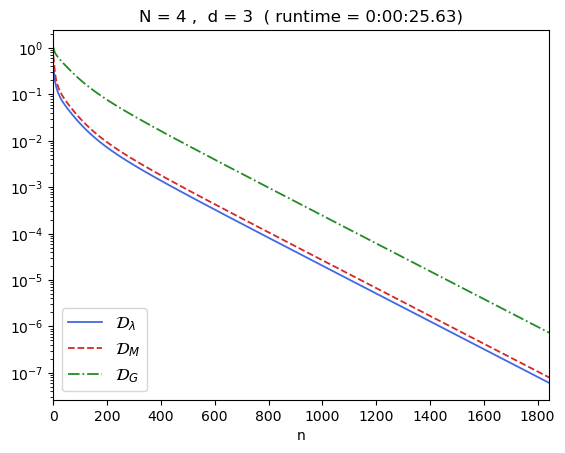

In [5]:
params_plot = {'name':dtype , 'plot_global':True, 'save_plot':False}

plot_data(d, num_of_qudits, results['edistance'], results['mdistance'], 
          results['gdistance'], results['runtime'], params = params_plot )

### Accelerated version

In [6]:
alfa, mu, bt = 1, 1e-10, 0


parameters_accel = {'max_iter': 50000, 'dtol': 1e-7, 'rho_gen': rho_gen, 'x_0':initial_seed,
              'save_iter_data': False, 'save_h5':False, 'seed':'mixed', 'accelerated':True,
              'iter_to_print':500, 'h5_data_label':'AME', 'h5_name': dtype,
                'alfa':alfa, 'mu':mu, 'bt':bt}

results_accel = accelerated_qmp(d, num_of_qudits, prescribed_marginals, rank = rank, 
                                prescribed_spectra = prescribed_spectra, params = parameters_accel)

prescribed rank mode..
_________________________________
      n     tdist     gdist
_________________________________
      1  8.47289E-01  1.04920E+00
    501  2.40534E-05  1.20368E-04


### Accelerated version with different parameters

In [7]:
alfa, mu, bt = 5, 5.85*1e-4, 0.585

parameters_accel1 = {'max_iter': 50000, 'dtol': 1e-7, 'rho_gen': rho_gen, 'x_0':initial_seed,
              'save_iter_data': False, 'save_h5':False, 'seed':'mixed', 'accelerated':True,
              'iter_to_print':500, 'h5_data_label':'AME', 'h5_name': dtype,
                'alfa':alfa, 'mu':mu, 'bt':bt}

results_accel1 = accelerated_qmp(d, num_of_qudits, prescribed_marginals, rank = rank, 
                                prescribed_spectra = prescribed_spectra, params = parameters_accel1)

prescribed rank mode..
_________________________________
      n     tdist     gdist
_________________________________
      1  9.91005E-01  1.07178E+00
    501  1.04883E-06  4.18114E-06


### Comparison

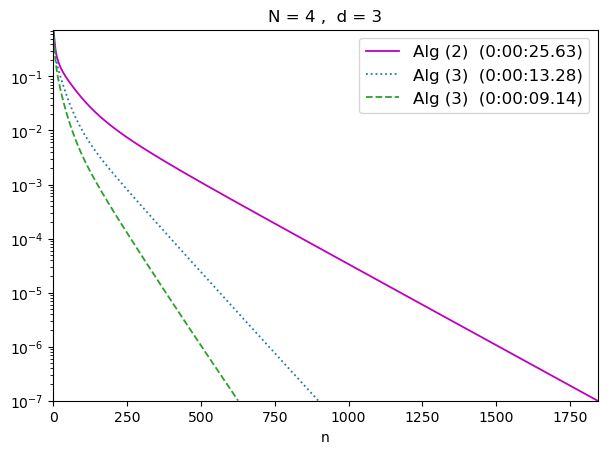

In [8]:
gdistance, runtime = results['tdistance'], results['runtime']
gdistance_accel, runtime_accel = results_accel['tdistance'], results_accel['runtime']
gdistance_accel1, runtime_accel1 = results_accel1['tdistance'], results_accel1['runtime']

name_of_plot = 'pure'
params = {'name':name_of_plot, 'save_plot':False}
compare_plots(d, num_of_qudits, gdistance, gdistance_accel,
              gdistance_accel1, runtime, runtime_accel, 
              runtime_accel1, params = params )


In the vertical axis the overall distance $\mathcal{D}_{T}$ is plotted in log scale. In the horizontal axis, the number of iterations.

The solid  (<font color='magenta'>magenta</font>) line corresponds to the **non-accelerated** version of the algorithm. The dotted (<font color='royalblue'>blue</font>) and dashed (<font color='forestgreen'>green</font>) lines correspond to the **accelerated** version of the algorithm for different choices of $\alpha$ and $\mu$